# Unit 4 Capstone - News Article Analysis & Classification

## John A. Fonte

---
---

### Instructions

1. Find 100 different entries from at least 10 different authors (articles?)
2. Reserve 25% for test set
3. cluster vectorized data (go through a few clustering methods)
4. Perform unsupervised feature generation and selection
5. Perform supervised modeling by classifying by author
6. Comment on your 25% holdout group. Did the clusters for the holdout group change dramatically, or were they consistent with the training groups? Is the performance of the model consistent? If not, why?
7. Conclude with which models (clustering or not) work best for classifying texts.

---
---

### About the Dataset

__Source:__ https://archive.ics.uci.edu/ml/datasets/Reuter_50_50#

__Description:__ This is a subset of the [Reuters Corpus Volume 1 (RCV1)](https://scikit-learn.org/0.17/datasets/rcv1.html). Specifically, this subset consists of the top 50 authors by article proliferation, with a total of 100 articles per each author within the combined training and testing sets.

---
---
# 1. Data Load and Cleaning

In [1]:
# basic imports
# will be doing other imports ad hoc
##### i.e., models and related functions

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [29]:
'''
Loading Data from Local Computer
Each author is a subfolder, and within each folder is a series of .txt files
The goal of this cell is to load all the contents of every subfolder into the 
DataFrame, while retaining the author designation for those works.
'''

from os import listdir

def multiple_file_load(file_directory):
    
    # identifying all author subfolders - appending them into list 
    
    authorlist = []
    textlist = []
    
    for author in listdir(file_directory):
        authorname = str(author)
        author_sub_directory = (file_directory + '/' + author) #author file path
    
    # identifying all files within each subfolder - 
    
        for filename in listdir(author_sub_directory):
            text_file_path = (author_sub_directory + '/' + filename) # text file path
            
            if (filename.lower().endswith('txt')):
                authorlist.append(authorname)
                textfile = open(text_file_path,'r') # this is how you open files
                substantive_text = textfile.read()  # this is how to read a file
                textlist.append(substantive_text)   # this is how to do something with that file
                textfile.close()                    # this is how to close the file 
                                                             # (you must close one before opening another!)
  # pushing the two lists into a dataframe 

    df = pd.DataFrame({'Author':authorlist, 'Text':textlist})
    
    return df
                

In [30]:
# loading training data (note the file path)
df_train = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50train')

In [31]:
df_train.head(3)

,Author,Text
0,AaronPressman,The Internet may be overflowing with new techn...
1,AaronPressman,The U.S. Postal Service announced Wednesday a ...
2,AaronPressman,Elementary school students with access to the ...


In [32]:
# Authors don't have space between the names
# adding the space in the authors...because I want it
import re
author_split = [re.findall('[A-Z][a-z]*', i) for i in df_train.Author]

In [33]:
#joining them back together
author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    

In [34]:
df_train['Author'] = pd.Series(author_join)
df_train.tail(3)

,Author,Text
2497,William Kazer,China issued tough new rules on the handling o...
2498,William Kazer,China will avoid bold moves in tackling its ai...
2499,William Kazer,Communist Party chief Jiang Zemin has put his ...


In [35]:
# Loading df_test, which is a separate csv file

df_test = multiple_file_load('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/C50/C50test')
df_test.head(3)

,Author,Text
0,AaronPressman,U.S. Senators on Tuesday sharply criticized a ...
1,AaronPressman,Two members of Congress criticised the Federal...
2,AaronPressman,Commuters stuck in traffic on the Leesburg Pik...


In [36]:
#another fix to Author column

author_split = [re.findall('[A-Z][a-z]*', i) for i in df_test.Author]

author_join = []

for couple in author_split:
    joined_string = couple[0] + ' ' + couple[1]
    author_join.append(joined_string)    
    
df_test['Author'] = pd.Series(author_join)

In [37]:
#Before I begin adding features, assignment asks for 25% data split, NOT 50/50
# See "GOAL" below for explanation as to how I am doing that.

'''GOAL:
Trying to get half of the datapoints OF EACH AUTHOR
in the testing set into a new DataFrame, which
will be concatenated onto the training set.
I will delete that from the testing set later.

Doing this instead of combining both and splitting 75/25 later 
ensures balanced data between the authors.
'''

def appendingdataframe(dataframe):
    appendabledataframe = pd.DataFrame(columns=['Author', 'Text'])
    
    for item in dataframe.Author.unique():
        df_testauthor = df_test[df_test['Author'] == item].copy() 
        appendabledataframe = appendabledataframe.append(df_testauthor[25:], 
                                                         ignore_index=True) # want half of df_testauthor!
    
    return appendabledataframe
    

In [38]:
# using appendabledataframe to avoid screwing up original data
# This is explicit inefficiency at the cost of being cautious

df_train2 = df_train.append(appendingdataframe(df_train), ignore_index=True)

# checking if the appending worked
len(df_train2)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

3750

In [39]:
# It worked!
df_train = df_train2.copy()

In [40]:
# doing same for df_test

df_test2 = df_test.append(appendingdataframe(df_train), ignore_index=True)

# checking if the appending worked
len(df_test2)

Looping through  Aaron Pressman
Looping through  Alan Crosby
Looping through  Alexander Smith
Looping through  Benjamin Kang
Looping through  Bernard Hickey
Looping through  Brad Dorfman
Looping through  Darren Schuettler
Looping through  David Lawder
Looping through  Edna Fernandes
Looping through  Eric Auchard
Looping through  Fumiko Fujisaki
Looping through  Graham Earnshaw
Looping through  Heather Scoffield
Looping through  Jane Macartney
Looping through  Jan Lopatka
Looping through  Jim Gilchrist
Looping through  Joe Ortiz
Looping through  John Mastrini
Looping through  Jonathan Birt
Looping through  Jo Winterbottom
Looping through  Karl Penhaul
Looping through  Keith Weir
Looping through  Kevin Drawbaugh
Looping through  Kevin Morrison
Looping through  Kirstin Ridley
Looping through  Kourosh Karimkhany
Looping through  Lydia Zajc
Looping through  Lynne O
Looping through  Lynnley Browning
Looping through  Marcel Michelson
Looping through  Mark Bendeich
Looping through  Martin Wolk

3750

In [41]:
# and now to drop the rows added to df_train from df_test

df_test2.drop_duplicates(keep=False, inplace=True)
len(df_test2)

1250

In [42]:
df_test = df_test2.copy()

# Text Cleaning

Arguably the most important part about working with text data is how to refine it for processing. As simple as they are, string substitutions such as `pd.replace` and regex's `re.sub` are common. I am also partial to `pd.Series.apply(lambda x: x.replace('...',''))`.  Additional text processing such as the exclusion of stop_words and lemmatization will be done after the raw text is pre-processed.

In [178]:
# cleaning text before feature analysis/engineering 

#--------------------------------------------------------------------

# CLEANING FUNCTION 1 - WORD AND PUNCTUATION/CHARACTER CLEANING

# EDIT: During first run-through, this function was very basic
# I have since implemented new cleaning features

# regex already imported as re

def text_cleaner(text):
    text = text.lower() # avoiding capitalization problems.
    
    text = re.sub(r'.\s*\\n[a-z]', r'\. [a-z]', text)
    text = re.sub(r'\.\s?([a-z])', r'\. \1', text)
    text = re.sub(r' u\. s\.(\s?)', r' u\.s\.\1', text) # next three lines are my attempt to join 'u. s.' to 'u.s.'
    text = text.replace('u. s.', 'u.s.')
    text = text.replace(r'u. s.', r'u.s.')
    text = re.sub(r'-', '', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub('[\[].*?[\]]', '', text)
    text = re.sub('.=.', '. .', text)
    text = text.replace('\\', '')
    text = re.sub(',', '', text) # I don't want punct screwing up lemmatization
    text = re.sub('\\n', '', text)
    text = re.sub(r'\\n', '', text) # I don't know which one works
    text = text.replace('\"', '')
    
    # rest of punctuation will be handled via lemmatization
    
    return text

In [179]:
# application of text cleaning functions

df_train['Text1'] = df_train['Text'].apply(lambda x: text_cleaner(x))
df_test['Text1'] = df_test['Text'].apply(lambda x: text_cleaner(x))

In [180]:
df_train['Text1'][1]

"the u. s. postal service announced wednesday a plan to boost online commerce by enhancing the security and reliability of electronic mail traveling on the internet. under the plan businesses and consumers can verify that email has not been tampered with and use services now available for ordinary mail like sending a certified letter.the leap from trading messages to buying and selling goods has been blocked by the fear of security threats robert reisner vice president of stategic planning said. to expand from local area networks and bilateral secure communications to wide use of electronic commerce will require a new generation of security services reisner said. cylink corp is developing a system for the post office to use to verify the identity of email senders. the system will enable people to register a digital signature with the post office that can be compared against electronic mail they send. if any tampering is discovered the postal service would investigate just like it inves

In [235]:
# CLEANING FUNCTION 2 - NUMBER CLEANING
'''
Whether it be phone numbers, page numbers, or just 
digits for no particular reason (which, yes, does happen),
numbers will become there own vectors and inevitably clog
up the vectorized feature space.

I am dropping all number columns because 
we are looking at words, not numbers!!!!!
'''

def phone_and_weird_num_deletion(text):
    final_text = text
    
    leading_zero_numbers = list(re.findall(r' 0\d+', text))
    phone_numbers = list(re.findall(r' ?\+?\d{1}?(\d{3}?|\d{4}?) \d{3} \d{4}', text))
    phone_num_no_space = list(re.findall(r' ?\+?(\d{10}?|\d{11}?)', text))
    total_deletions = leading_zero_numbers + phone_numbers + phone_num_no_space
    
    if len(total_deletions) != 0:
        print(len(total_deletions))
        for item in total_deletions:
            final_text = final_text.replace(item, '')
        return final_text
    
    else:
        return text
                               
#----------------------------------------------
        
# DON'T USE THE BELOW FUNCTION!
# It appears there are a lot of good numbers there

#-----------------------------------------------

#def string_num_deletion(text):
#    final_text = text
#    
#    dates = [str(x) for x in list(range(1900, 2026))]
#    plural_dates = re.findall(r' (\d{2}?|\d{4}?)s/g', text)
#    money_values = re.findall(r' \$\d+/g', text)
#    common_num = list(range(1000))
#    total_exceptions = dates + plural_dates + money_values + common_num
#                              
#    
#    num_token = re.findall(r'\d+[^snrt]?[^tdh]?\.*\d*/g', text) # finding all numbers that are not ordinals
#                                                                # also using "." for decimal findings
#    if len(num_token) != 0:
#        for x in num_token not in total_exceptions:
#            final_text = num_token.apply(lambda x: final_text.replace(x, ''))
#        
#        return final_text
#    
#    else:
#        return text

In [236]:
df_train['Text2'] = df_train['Text1'].apply(lambda x: phone_and_weird_num_deletion(x))
df_test['Text2'] = df_test['Text1'].apply(lambda x: phone_and_weird_num_deletion(x))

# The list comprehension inside a loop makes this run for a total of 10seconds

1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
11
11
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [224]:
# adding cleaned text back into original text
df_train['Text'] = df_train['Text2']
df_test['Text'] = df_test['Text2']

df_train.drop(columns=['Text1', 'Text2'], axis=1, inplace=True)
df_test.drop(columns=['Text1', 'Text2'], axis=1, inplace=True)
df_train.head(3)

,Author,Text
0,Aaron Pressman,the internet may be overflowing with new techn...
1,Aaron Pressman,the u. s. postal service announced wednesday a...
2,Aaron Pressman,elementary school students with access to the ...


---

# Adding Features

Now that the text is cleaned, we can calculate basic numerical features off of that cleaned text.

In [225]:
# adding some numerical features for text analysis

df_train['Raw Character Count'] = df_train['Text'].apply(lambda x: len(x))
df_train['Raw Word Count'] = df_train['Text'].apply(lambda x: len(x.split()))

In [226]:
# doing same for df_test

df_test['Raw Character Count'] = df_test['Text'].apply(lambda x: len(x))
df_test['Raw Word Count'] = df_test['Text'].apply(lambda x: len(x.split()))

In [227]:
# creating numerical classes for authors:
# I feel like one hot encoding would've screwed things up, so I did "factorize"

df_train['AuthorNum'] = pd.factorize(df_train.Author)[0]
df_train['AuthorNum'] = df_train['AuthorNum'].astype("category")

In [228]:
# and same for df_test...

df_test['AuthorNum'] = pd.factorize(df_test.Author)[0]
df_test['AuthorNum'] = df_test['AuthorNum'].astype("category")

# Vectorizing! Changing Text to Numbers

Our text is ready to be processed. How are we going to do that? __Vectorization.__ This process turns words into vectors. These vectors are the values that we use for modeling.

Sklearn offers two popular vectorizing models (although there are many others), _Bag of Words_ ("CountVectorizer") and _Term Frequency-Inverse Document Frequency_ ("TfidfVectorizer"). Bag of words vectors represent raw counts of each vectorized word found in a given article, and tfidf vectors represent inverse ratios of the word's frequency in a given article.

### Okay cool...so what are we adding to the vectorizers?

These two sklearn models vectorize _individual words_ only. There are more sophisticated models that can vectorize whole sentences at once. If you want to use count or tfidf for sentences, we can __tokenize__ the articles into sentences, which are broken into their own individual dataframe index values, and then use one of the two vectorizers to analyze the individual words in those sentences. We will not do that here: the articles are not uniform size, and so tokenizing the articles into words would imbalance the data. It also will use an unnecessaryamount of resources to do this.

Note that ___sklearn models do the tokenization___! If you choose to tokenize yourself via the spaCy module, you will have to join back the text and then _re-tokenize_ it through the vectorizer.  We may need to do this instead of easily pushing in the raw (but cleaned) text documents; it appears that sklearn vectorizers do not have any native lemmatization hyperparameters (believe me, I looked..._a lot..._), and I believe lemmatization is crucial for analysis.

From here we will do three things: run raw text documentation through (1) countvectorizer and (2) tfidfvectorizer. Separately, we will (3) lemmatize and tokenize the text with the spaCy module, and once that is done, rejoin the lemmatized tokens into raw text which we will push through tfidfvectorizer. We will analyze the data via __Latent Semantic Analysis__, where we will choose the best dataset to work with (and in turn, determine which way to df_test dataset).

In [275]:
# STEP 1 - COUNTVECTORIZER

# importing model
from sklearn.feature_extraction.text import CountVectorizer

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
cv = CountVectorizer(ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                     stop_words='english', # excluding stopwords
                     min_df=5,             # HUGE parameter - excluding all words not appearing more than 5 times!
                     max_features=12500,   # keeping a limit on how many features there should be
                    )                      # max_features takes TOP frequency features

In [276]:
# vectorizing only the training data, as requested

count_vectors = cv.fit_transform(df_train['Text'])
#dense = tfidf_vectors.todense() ----- for a feature space of this size
#denselist = dense.tolist()     ------ fixing sparsity will crash/run out of memory

token_names = cv.get_feature_names()

# creating dataframe from vectors (a separate process)
count_vectorized_df_train = pd.DataFrame(count_vectors.toarray(), columns=token_names)
count_vectorized_df_train.shape

(3750, 12500)

In [278]:
count_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0p', '10',
       '100', '1000', '10000', '100000', '101', '102', '103', '104'],
      dtype='object')

In [279]:
'''
I have no idea why the preceding 0 numbers weren't taken out
of the text - they are now made into vectors. I am manually dropping those vectors.
'''

count_vectorized_df_train = count_vectorized_df_train.iloc[:, 12:].copy()

In [280]:
#---------------------------------------------------------------------
# STEP 2 - TfidfVECTORIZER

# doing same and comparing with countvec
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
tfidf = TfidfVectorizer(ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                        stop_words='english', # excluding stopwords
                        min_df=5,             # HUGE parameter - excluding all words not appearing more than 2 times
                        max_features=12500,    # tfidf goes much faster than countvec
                       )                      # max_features takes TOP frequency features

In [281]:
tfidf_vectors = tfidf.fit_transform(df_train['Text'])
#dense = tfidf_vectors.todense() ----- for a feature space of this size
#denselist = dense.tolist()     ------ fixing sparsity will crash/run out of memory

token_names = tfidf.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidf_vectorized_df_train = pd.DataFrame(tfidf_vectors.toarray(), columns=token_names)
tfidf_vectorized_df_train.shape

(3750, 12500)

In [283]:
tfidf_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0p', '10',
       '100', '1000', '10000', '100000', '101', '102', '103', '104'],
      dtype='object')

In [284]:
tfidf_vectorized_df_train = tfidf_vectorized_df_train.iloc[:,12:].copy()

### The difference between the two?

There really isn't: the output vectors represent the same thing. The difference is that countvec has raw number vectors, and tfidf is the log inverse frequency of those counts.

__Which one should we use for modeling?:__

The answer is __tfidf vectors__. The inverse frequency offers the benefit of normalizing the data, which is critical for clustering purposes.

We will now do a third vectorization with out spaCy lemmatization and modeling.

In [288]:
# importing spaCy, which will allow for lemmatization
import spacy

# WILL TAKE A WHILE TO LOAD!

nlp = spacy.load('en')
df_train['Spacy-ed Text'] = df_train['Text'].apply(lambda text: nlp(text))
df_test['Spacy-ed Text'] = df_test['Text'].apply(lambda text: nlp(text))

In [289]:
df_train.head(3)

,Author,Text,Raw Character Count,Raw Word Count,AuthorNum,Spacy-ed Text
0,Aaron Pressman,the internet may be overflowing with new techn...,1976,319,0,"(the, internet, may, be, overflowing, with, ne..."
1,Aaron Pressman,the u. s. postal service announced wednesday a...,2557,414,0,"(the, u., s., postal, service, announced, wedn..."
2,Aaron Pressman,elementary school students with access to the ...,482,71,0,"(elementary, school, students, with, access, t..."


In [290]:
# defining lemmatization model

def lemma_list(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
            
    # Build and return a Counter object containing word counts.
    return lemmas

def lemmatized_text(text, include_stop=True):
    
    # Build a list of lemmas.
    # Strip out punctuation and, optionally, stop words.
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_) # this is why we needed to spacy/nlp-ify the texts first
    
    lemma_text = ' '.join(lemmas)
            
    # Build and return a Counter object containing word counts.
    return lemma_text

In [297]:
# doing third model with lemma text

# instantiating model

# using default values for vectorizer's "preprocessor" and "tokenizer"
tfidflemma = TfidfVectorizer(preprocessor=lemmatized_text,
                             ngram_range=(1, 1),   # this is default, but just showing that we're using individual words
                             stop_words='english', # excluding stopwords
                             min_df=5,             # HUGE parameter - excluding all words not appearing more than 5 times
                             max_features=12500,   # tfidf goes much faster than countvec
                            )                      # max_features takes TOP frequency features

In [298]:
tfidflemma_vectors = tfidflemma.fit_transform(df_train['Spacy-ed Text'])
token_names = tfidflemma.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidflemma_vectorized_df_train = pd.DataFrame(tfidflemma_vectors.toarray(), columns=token_names)
tfidflemma_vectorized_df_train.shape

(3750, 10854)

In [300]:
tfidflemma_vectorized_df_train.columns[:20]

Index(['00', '01', '02', '0200', '025', '03', '04', '05', '0500', '06', '07',
       '0700', '08', '09', '0p', '10', '100', '1000', '10000', '100000'],
      dtype='object')

In [301]:
tfidflemma_vectorized_df_train = tfidflemma_vectorized_df_train.iloc[:,16:].copy()

__Analysis:__

Looking at the shapes between tfidf and the lemmatized tfidf, the feature space for lemmatized tfidf is smaller, which means (1) less computational overhead and (2) less variance loss when performing dimensionality reduction.

For this reason: __we will be using the DataFrame tfidflemma_vectorized_df_train for modeling moving forward.__

In [307]:
# doing the same for df_test, to save for later:

tfidflemma_vectors = tfidflemma.fit_transform(df_test['Spacy-ed Text'])
token_names = tfidflemma.get_feature_names()

# creating dataframe from vectors (a separate process)
tfidflemma_vectorized_df_test = pd.DataFrame(tfidflemma_vectors.toarray(), columns=token_names)
tfidflemma_vectorized_df_test.shape

(1250, 5825)

In [310]:
tfidflemma_vectorized_df_test = tfidflemma_vectorized_df_test.iloc[:,11:].copy()

---

# A Quick Aside:

It is important to keep tabs of all the kinds of data that has so far been created, transformed, and/or deleted. Specifically, we now have two sets of datasets: raw text datasets (`df_train` and `df_test`) and the various vectorized datasets (e.g., `tfidflemma_vectorized_df_train`, with df_test to be vectorized as well).

Before we continue, let's see these datasets and save them to csv's, so we don't have to do the analysis all over again.^

---
^From experience, when the kernel is reset, pandas cannot properly import the spaCy-ed data because spaCy is not imported at that time. This means you would have to spaCy the text data all over again even though you are importing a dataframe with the spaCy transformed data. It doesn't make much sense, since the transformation calculation is complete and we are just saving the outputs, but I don't question the code gods. Just to be safe though: __IMPORT SPACY _BEFORE_ YOU IMPORT THE DATAFRAME!__

In [303]:
# a little out of order, but adding this additional feature, just for fun:
df_train['Meaningful Word Count'] = df_train['Spacy-ed Text'].apply(lambda x: len(lemma_list(x)))
df_test['Meaningful Word Count'] = df_test['Spacy-ed Text'].apply(lambda x: len(lemma_list(x)))

In [311]:
# saving the dataframes via pd.to_csv!!!!!!
# commented out because I only need to do this once

#df_train.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/NEW_COMPLETE_NLP-train.csv',
#                index=False)
#
#df_test.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/NEW_COMPLETE_NLP-test.csv',
#               index=False)
#
#tfidflemma_vectorized_df_train.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/VECTORIZED-train.csv',
#               index=False)
#
#tfidflemma_vectorized_df_test.to_csv('D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/VECTORIZED-test.csv',
#               index=False)

---

## Feature Analysis: Latent Semantic Analysis (LSA)

As mentioned before, vectorized data is extremely sparse (although for my vectorizer, I kinda forced it not to be too sparse via the hyperparameter `min_df=5`). Performing machine learning across thousands of features is computationally heavy, and likely not all that effective in explaining variance.  We need to employ a dimensionality reduction technique.

For text data, the proper dimensionality reduction algorithm is __Singular Value Decomposition (SVD).__ Here, vectors are reduced down and compared with each other, yielding components. This is better than using PCA because: (1) SVD works better with sparse datasets than PCA does, and (2) PCA works on a normal distribution, which is good for continuous data, but terrible for non-continuous data (cough text data cough). Using SVD for dimensionality reduction is crucial for clustering algorithms and general modeling.

__Latent Semantic Analysis (LSA)__ uses SVD on sparse text data to generate components that best "cluster" datapoints based on similarity, whether that similarity be the raw words, topic, order of words, etc. For all intents and purposes, SVD and LSA are used synonymously.

---
The downside to reducing the feature space down is that some explained variance is lost. Accordingly, we need to determine what is the best tradeoff between feature space simplicity for modeling and accuracy by retention of explained variance. How do we determine this? __Well, we kinda test it...__

In [312]:
# importing SVD

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to check varying component sizes (see bottom)
component_datapoints = [5, 10, 50, 100, 250, 500, 1000, 2000, 3500, 5000]
component_log = [np.log(x) for x in component_datapoints]

# finding y values for SVD analysis graph
variance_explained_percent = []

# running loop on this

for i in component_datapoints:
    svd = TruncatedSVD(i)                                           # SVD instantiation
    lsa = make_pipeline(svd, Normalizer(copy=False))                # model instantiation
    X_train_lsa = lsa.fit_transform(tfidflemma_vectorized_df_train) # fit model
    
    variance_explained = svd.explained_variance_ratio_
    total_variance = variance_explained.sum()
    
    variance_explained_percent.append(total_variance*100)
    
# -----------------------------------------------------------------
'''
This loop was VERY VERY VERY VERY computationally heavy. Took forever!
For future reference so you don't have to re-run, 

variance_explained_percent = 
[5.42, 9.41, 23.86, 33.06, 49.03, 
64.11, 80.56, 94.80, 99.98, 100.00]
'''
a='hi' # setting this here so the above string isn't outputted when run

In [316]:
type(variance_explained_percent)

list

In [321]:
# setting up graphing data, because seaborn HATES lists!
seaborndf = pd.DataFrame({'log(Number of Components)': component_log})
seaborndf['Percent Variance Captured by Totality of Components'] = variance_explained_percent
seaborndf.head(3)

,log(Number of Components),Percent Variance Captured by Totality of Components
0,1.609438,5.421886
1,2.302585,9.412167
2,3.912023,23.862891


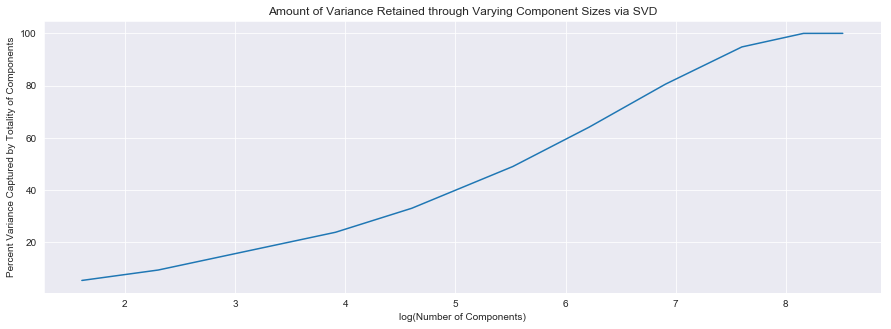

In [326]:
# graphing SVD analysis

sns.set_style('darkgrid')
plt.figure(figsize=(15,5))

sns.lineplot(x='log(Number of Components)', 
             y='Percent Variance Captured by Totality of Components', 
             data=seaborndf,
            markers=component_log)
plt.title('Amount of Variance Retained through Varying Component Sizes via SVD')
plt.show()

__Analysis:__ Based on this logarithmic analysis, you have to pile on the components to retain variance. Judging by the values found in `variance_explained_percent`, when compared to `component_datapoints`, __580 components__, or approximately 10% of the feature space, sounds good to me for the following:

---
---
# Table of Contents for Remainder of Project

1. Setting up X Input Data for Modeling
    - Creating SVD-Truncated feature space
    - Create separate 2D SVD-Truncated feature space for graphing (may need to do PCA...)
    - Perform LSA unsupervised feature analysis (separate from unsupervised clustering)
    - Do all of the above for testing feature space too
<br> <br>
2. Unsupervised Data Modeling (for both training and testing set)
    - K-Means clustering
        - K-Elbow analysis
        - Mini-batch sampling
    - Mean-shift clustering
    - t-SNE clustering
    - Analysis and comparison
<br> <br>
3. Supervised Classification Modeling
    - Logistic Regression with LASSO Penalty
    - K-Nearest Neighbors
    - SVM Classifier
    - Random Forest
    - AdaBoosting Ensemble Model
<br> <br>
4. Final Analysis
    - Discussion of best models and shortcomings
    
---
---

# 1. Setting up X

In [328]:
# STEP 1: SETTING UP DIMENSION-REDUCED DATA

# Set up vectorized LSA for input and unsupervised LSA analysis

# although same dimensionality reduction, 
# making two pipelines to get two different variance ratios (see bottom of cell)
svd1=TruncatedSVD(580)
svd2=TruncatedSVD(580)

lsa1 = make_pipeline(svd1, Normalizer(copy=False))
lsa2 = make_pipeline(svd2, Normalizer(copy=False))

X_train_lsa = lsa1.fit_transform(tfidflemma_vectorized_df_train)

X_test_lsa = lsa2.fit_transform(tfidflemma_vectorized_df_test)

#-------------------------------------------------------
'''
While 580 components is a good reduced feature space 
for our vectorized datasets, we need to graph in 2D,
(we *can* do 3D, but it's not necessary for this kind of data).
Therefore, we need to truncate again into 2 dimensions for purposes of graphing
'''

svd_graph=TruncatedSVD(2)
lsa_graph = make_pipeline(svd_graph, Normalizer(copy=False))

X_train_lsa_graph = lsa_graph.fit_transform(tfidflemma_vectorized_df_train)
X_test_lsa_graph = lsa_graph.fit_transform(tfidflemma_vectorized_df_test)

#--------------------------------------------------------

variance_explained_train = svd1.explained_variance_ratio_
total_variance_train = variance_explained_train.sum()

variance_explained_test = svd2.explained_variance_ratio_
total_variance_test = variance_explained_test.sum()

print("Percent variance captured by the totality of the components for the TRAINING dataset: ",
      round(total_variance_train*100, 4))

print("\nPercent variance captured by the totality of the components for the TESTING dataset: ",
      round(total_variance_test*100, 4))


Percent variance captured by the totality of the components for the TRAINING dataset:  67.594

Percent variance captured by the totality of the components for the TESTING dataset:  88.379


In [331]:
X_train_lsa.shape

(3750, 580)

### LSA Analysis

We are able to gain some insight into which input LSA components provide the greatest explanation of variance in the dataset, and which authors' variances are being explained. This is just preliminary analysis before delving into the real unsupervised machine learning analysis.

In [337]:
# finding components in light of AUTHOR
components_train = pd.DataFrame(X_train_lsa,index=df_train['Author'])
components_test = pd.DataFrame(X_test_lsa,index=df_test['Author'])

# five example components:
for i in range(5):
    print('\nComponent {} for Training Set:\n'.format(i))
    print(components_train.loc[:,i].sort_values(ascending=False)[:5])


Component 0 for Training Set:

Author
Mark Bendeich      0.649276
Graham Earnshaw    0.632674
Eric Auchard       0.630504
Bernard Hickey     0.624931
Bernard Hickey     0.621308
Name: 0, dtype: float64

Component 1 for Training Set:

Author
Peter Humphrey    0.743966
Peter Humphrey    0.710732
William Kazer     0.706919
Tan Ee            0.703369
Peter Humphrey    0.699339
Name: 1, dtype: float64

Component 2 for Training Set:

Author
David Lawder    0.561701
David Lawder    0.556036
David Lawder    0.554305
David Lawder    0.553527
David Lawder    0.551263
Name: 2, dtype: float64

Component 3 for Training Set:

Author
David Lawder    0.598727
David Lawder    0.595361
David Lawder    0.585853
David Lawder    0.583259
David Lawder    0.583176
Name: 3, dtype: float64

Component 4 for Training Set:

Author
Sarah Davison    0.374223
Sarah Davison    0.355031
Tan Ee           0.354134
Todd Nissen      0.351394
David Lawder     0.349255
Name: 4, dtype: float64


__Analysis:__ Here we can see which authors are most similar to each other in light of the 580 (rather abstract) components. 

We can safely conclude that _at least in some aspects_, no one quite writes like David Lawder!

In [338]:
for i in range(5):
    print('\nComponent {} for Training Set:\n'.format(i))
    print(components_test.loc[:,i].sort_values(ascending=False)[:5])


Component 0 for Training Set:

Author
Kevin Drawbaugh    0.580515
Nick Louth         0.563699
Eric Auchard       0.556404
Graham Earnshaw    0.554592
Tim Farrand        0.553483
Name: 0, dtype: float64

Component 1 for Training Set:

Author
Peter Humphrey    0.761377
Peter Humphrey    0.734077
Peter Humphrey    0.723136
Peter Humphrey    0.704783
Benjamin Kang     0.693950
Name: 1, dtype: float64

Component 2 for Training Set:

Author
Heather Scoffield    0.467673
Heather Scoffield    0.467673
Heather Scoffield    0.457429
Darren Schuettler    0.456426
Darren Schuettler    0.448331
Name: 2, dtype: float64

Component 3 for Training Set:

Author
Darren Schuettler    0.650693
Darren Schuettler    0.648150
Lydia Zajc           0.595493
Darren Schuettler    0.592159
Lydia Zajc           0.591638
Name: 3, dtype: float64

Component 4 for Training Set:

Author
William Kazer      0.424682
Graham Earnshaw    0.414584
Graham Earnshaw    0.410696
Graham Earnshaw    0.408224
Graham Earnshaw    0.3

__Analysis:__ Components appear to be much more consistent in the training set. This makes sense, as we know that LSA explains 20% more variance in the testing dataset than in the training dataset.  This is likely due to the __curse of dimensionality.__ Flattening thousands of vectors down to 580 components will result in crowding and overlapping of data, thus making it more difficult to discern text from Author A from Author B.

Because the testing feature space (n=5825) was originally a little over half of that of the training feature space (n=10854), it can work with 580 components more easily.  This is a bias to be taken into account when moving forward.

In [397]:
# This is as good of a time as ever to instantiate training and testing sets
X_train = components_train.copy().reset_index()
X_test = components_test.copy().reset_index()
y_train = df_train['AuthorNum']
y_test = df_test['AuthorNum']

In [402]:
# Taking target variable out of feature space
X_train = X_train.drop('Author', axis=1)
X_test = X_test.drop('Author', axis=1)

# 2. Unsupervised Learning - Clustering Analyses

Clustering analysis is meant to find which features are most similar to each other (and in the same vein, which ones are most dissimilar to each other). We can analyze which features fall into which clusters via a `pd.crosstab` analysis.

## K-Means

K-Means Clustering is an iterative trial and error process that minimizes a means distance between similar points. The "K" is the number of cluster points to designate. But how do we know what is the number of clusters that best accurately describes our data? 

__Answer:__ Whichever number of clusters that yields the highest __Silhouette Score.__

---

### What is a Silhouette Score?

A Silhouette value is a distance measure of a sample's distance to its cluster's center (a) and its distance to the center of the nearest cluster that the sameple is not a part of (b). A __Silhouette Coefficient__ is the average of all of these values for a given cluster. [As used in sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html), a __Silhouette Score__ is the average of all Silhouette Coefficients across all clusters.

Silhouette Coefficients (and by nature of the metric, Silhouette Scores too) range from (-1,1), with "1" being the best score. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In short, a silhouette score is a __measure of how accurate the clustering is.__ 

---

To determine the K that yields the highest Silhouette Score, we will use the __K-Elbow Visualizer__. The "Elbow Method" is a simple iterative method that measures the accuracies for a range of k-sized clustering.  The point of inflection (the "elbow" of the graph) is usually the indicator that the model fits best with that point (in this case, that the model fits best with that particular k-number of clusters).

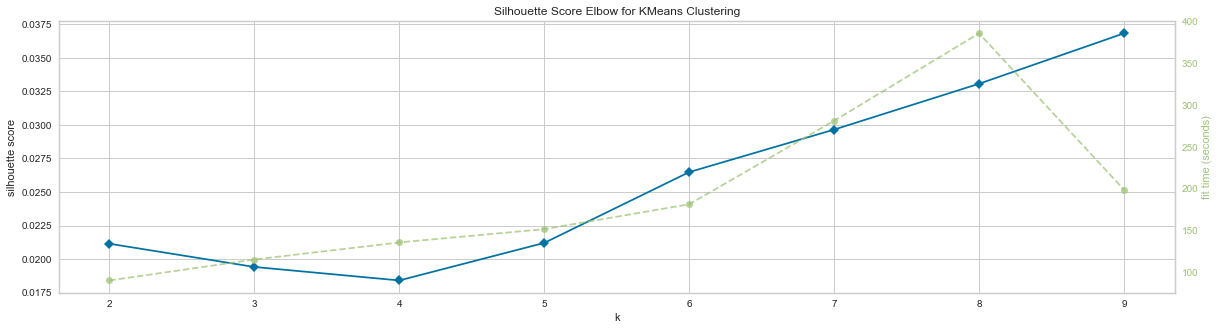

In [340]:
# K-MEANS CLUSTERING

# relative K-Means imports

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Additional import for the KElbowVisualizer method 
from yellowbrick.cluster import KElbowVisualizer

#---------------------------------------------------------

# Instantiate a scikit-learn K-Means model 
# really cranking on these iterations, 
# because I have yet to see any overfitting or significant computational overload...

# ...with PCA. Fitting the model via LSA makes it take 10+ minutes to run

model = KMeans(n_init=500, max_iter=500000, tol=0.000001, random_state=42)

#fit model - preprocessing already complete, 
# so no dimensionality done here

model.fit(X_train_lsa)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

# Fit the data and visualize 

plt.figure(figsize=(20,5))
visualizer.fit(X_train_lsa) 
visualizer.poof() 

In [342]:
# saving the above graph because that calculation took forever
# commented out as to do only once...

#visualizer.poof(outpath='D:/Github/Data-Science-Bootcamp/CAPSTONE - Unsupervised Learning/K-MeansElbowTRAIN.png')

<Figure size 576x396 with 0 Axes>

__Analysis:__ The good news is that there is a clear trend that more clusters yields a higher Silhouette Score. The bad news is that the Silhouette Score is dismal; it does not exceed 5%.

As you will see below, __LSA unfortunately has a really tough time with clustering.__  `StandardScaler()` and other pipeline scaling makes no difference. I'll be honest: I'm not sure why. Perhaps LSA components retain their shape during the dimensionality reduction, and in doing so, lose a lot of variance. 

PCA does not do that: it aims to retain its variance during the dimensionality reduction. For clustering models, we will use PCA. However, we will go back to LSA once unsupervised learning is done.

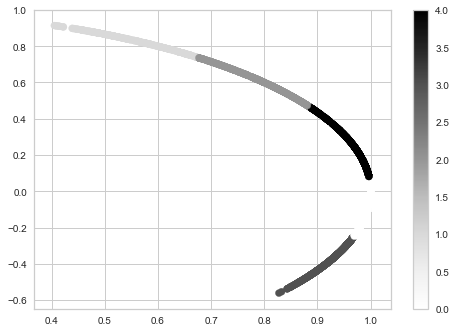

Author,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Cluster Label,,,,,,,,,,,,,,,,,,,,,
0,57,53,60,4,39,32,44,46,45,17,...,50,32,12,1,38,2,25,25,53,3
1,0,0,0,9,0,0,0,0,0,0,...,1,0,27,11,0,56,0,0,0,7
2,0,0,0,52,0,0,0,0,0,0,...,2,0,19,45,0,11,0,0,0,35
3,4,17,14,0,35,43,29,28,28,58,...,9,43,0,0,37,0,50,50,20,0
4,14,5,1,10,1,0,2,1,2,0,...,13,0,17,18,0,6,0,0,2,30


In [346]:
# using the df_test set for this example
# The example shows that LSA is NOT GOOD for clustering - stick with PCA

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
scaler = StandardScaler()

# retaining LSA reduction, but adding StandardScaler

kmeans = KMeans(n_clusters=5, random_state=42)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans).fit(X_train_lsa_graph)
labels = pipeline.predict(X_train_lsa_graph)


#---------------------------------------------------------------------

y = df_train['AuthorNum']
dfkmeans = pd.DataFrame({'Cluster Label':labels, 'Author':y})
ct = pd.crosstab(dfkmeans['Cluster Label'], dfkmeans['Author'])

cluster_centers = kmeans.cluster_centers_
xcenters = cluster_centers[:,0]
ycenters = cluster_centers[:,1]
xcenlist = list(xcenters)
ycenlist = list(ycenters)

centerdf = pd.DataFrame({'Xcenter':xcenters, 'Ycenter':ycenters})

# Plotting kMeans
plt.scatter(x=X_train_lsa_graph[:, 0], y=X_train_lsa_graph[:, 1], c=labels)
plt.colorbar()
plt.show()


ct

In [348]:
# re-running the model but with PCA and not LSA
# setting up PCA

X_pca = PCA(2).fit_transform(tfidflemma_vectorized_df_train)
X_pca_test = PCA(2).fit_transform(tfidflemma_vectorized_df_test)

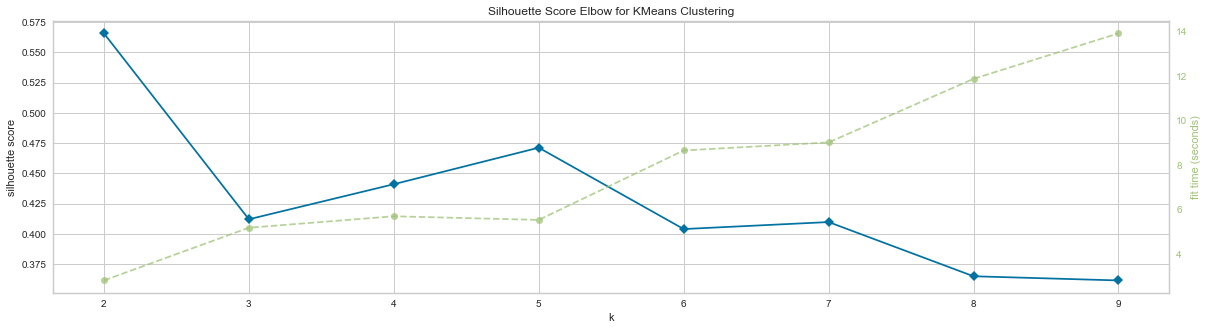

In [349]:
# redoing K-Elbow analysis with the new feature space

model = KMeans(n_init=500, max_iter=500000, tol=0.00001, random_state=42)

# re-instantiating the visualizer model and plotting it
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

plt.figure(figsize=(20,5))
visualizer.fit(X_pca) 
visualizer.poof() 

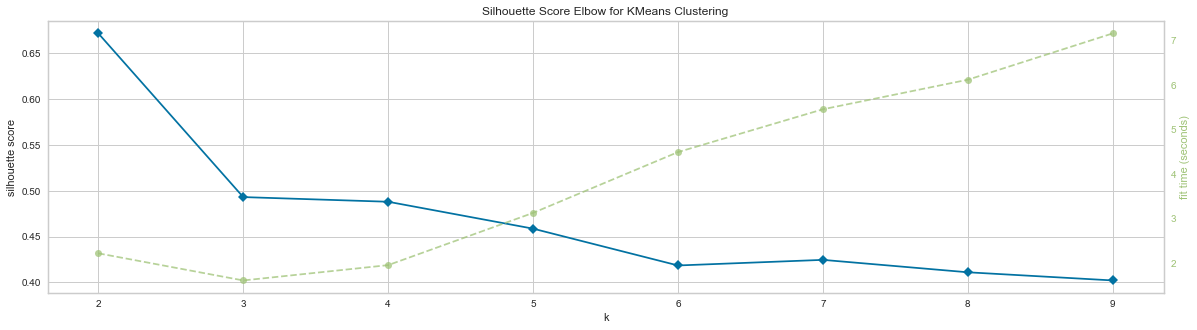

In [409]:
# doing same for testing set:

# redoing K-Elbow analysis with the new feature space

model = KMeans(n_init=500, max_iter=500000, tol=0.00001, random_state=42)

# re-instantiating the visualizer model and plotting it
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=True)

plt.figure(figsize=(20,5))
visualizer.fit(X_pca_test) 
visualizer.poof() 

__Analysis:__ Significantly better with PCA for both training and testing datasets.  Now that we know how many cluster centers to do (__k=2 has the highest Silhouette Score)__, we can finally do clustering right...

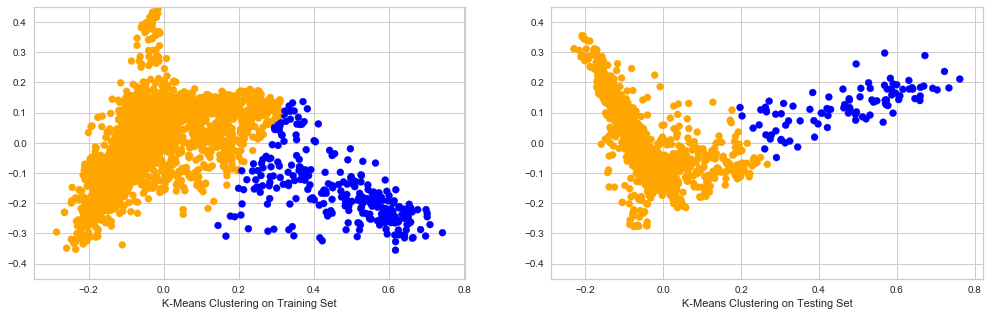

Training cluster 0 has center coordinates of: (-0.21, 0.1)
Training cluster 1 has center coordinates of: (2.79, -1.25)

Crosstab analysis for Training dataset is:
 Author         0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  \
Cluster Label                                         ...                       
0              75  75  75  73  75  75  75  75  75  75 ...  75  75  30  65  75   
1               0   0   0   2   0   0   0   0   0   0 ...   0   0  45  10   0   

Author         45  46  47  48  49  
Cluster Label                      
0              12  75  75  75  63  
1              63   0   0   0  12  

[2 rows x 50 columns]


Testing cluster 0 has center coordinates of: (-0.24, -0.09)
Testing cluster 1 has center coordinates of: (2.88, 1.02)

Crosstab analysis for Testing dataset is:
 Author         0   1   2   3   4   5   6   7   8   9  ...  40  41  42  43  44  \
Cluster Label                                         ...                       
0              25 

In [411]:
# re-doing K-Means given (1) PCA is the way to go and 
# (2) we know that K=2 is the best score for clustering

# setting up model
X_pca = PCA(2).fit_transform(X_train)
X_pca_test = PCA(2).fit_transform(X_test)

scaler = StandardScaler()
kmeans1 = KMeans(n_clusters=2, n_init=500, max_iter=500000, tol=0.0001)
kmeans2 = KMeans(n_clusters=2, n_init=500, max_iter=500000, tol=0.0001)

pipeline1 = make_pipeline(scaler, kmeans1).fit(X_pca)
labels1 = pipeline1.predict(X_pca)

pipeline2 = make_pipeline(scaler, kmeans2).fit(X_pca_test)
labels2 = pipeline2.predict(X_pca_test)

#-----------------------------------------------------------------------

# should've adjusted this a while ago...
pd.set_option('display.max_colwidth', 250)

#-----------------------------------------------------------------------

dfkmeans1 = pd.DataFrame({'Cluster Label':labels1, 'Author':y_train})
ct1 = pd.crosstab(dfkmeans1['Cluster Label'], dfkmeans1['Author'])

dfkmeans2 = pd.DataFrame({'Cluster Label':labels2, 'Author':y_test})
ct2 = pd.crosstab(dfkmeans2['Cluster Label'], dfkmeans2['Author'])

#forcing colors

color_list1 = []
color_list2 = []

for value in labels1:
    if value == 0:
        color_list1.append('orange')
    else:
        color_list1.append('blue')
        
for value in labels2:
    if value == 0:
        color_list2.append('orange')
    else:
        color_list2.append('blue')

#--------------------------------------------------------
# setting up analysis to obtain cluster center coordinates

cluster_centers1 = kmeans1.cluster_centers_
xcenters1 = cluster_centers1[:,0]
ycenters1 = cluster_centers1[:,1]
xcenlist1 = list(xcenters1)
ycenlist1 = list(ycenters1)


cluster_centers2 = kmeans2.cluster_centers_
xcenters2 = cluster_centers2[:,0]
ycenters2 = cluster_centers2[:,1]
xcenlist2 = list(xcenters2)
ycenlist2 = list(ycenters2)

#------------------------------------------------------------

# Plotting kMeans

plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=color_list1)
plt.ylim(-.45,.45)
plt.xlabel('K-Means Clustering on Training Set')

plt.subplot(1,2,2)
plt.scatter(x=X_pca_test[:, 0], y=X_pca_test[:, 1], c=color_list2)
plt.ylim(-.45,.45)
plt.xlabel('K-Means Clustering on Testing Set')

plt.show()

#-------------------------------------------------------------
for i in range(0, len(xcenlist1)):
    print('Training cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist1[i], 2), 
                                                                  round(ycenlist1[i], 2)))

print('\nCrosstab analysis for Training dataset is:\n', ct1)
    
print('\n')

for i in range(0, len(xcenlist)):
    print('Testing cluster {} has center coordinates of: ({}, {})'.format(i, 
                                                                  round(xcenlist2[i], 2), 
                                                                  round(ycenlist2[i], 2)))


print('\nCrosstab analysis for Testing dataset is:\n', ct2)

__Analysis:__

It appears the explanatory power of these clusters is limited. For both the training and testing datasets, most of the authors are clustered in Cluster 0. While this explains that the ones primarily clustered in Cluster 1 suggest special characteristics, it does not give much information for all the authors clustered in Cluster 0.

---

While visualization is fun, it limits our components to 2 dimensions, which severely impacts our variance. We can still do cross-tabs with higher dimensions. To do this, we will implement

## Mini-batch K-Means

Mini-batch performs the same iterative analysis as K-Means clustering, but it takes subsamples ("mini-batches") for each iteration to avoid overfitting and higher variance analysis.

We will execute mini-batch K-Means using a higher PCA dimensionality.

In [412]:
# MODEL - MINI-BATCH K-MEANS
from sklearn.cluster import MiniBatchKMeans

# we will reset the dimensionality to our original amount - 580
X_pca = PCA(580).fit_transform(X_train)
X_pca_test = PCA(580).fit_transform(X_test)

scaler = StandardScaler()
kmini1 = MiniBatchKMeans(init='random',
                         n_clusters=2,
                         batch_size=200)

kmini2 = MiniBatchKMeans(init='random',
                         n_clusters=2,
                         batch_size=200)

pipeline1 = make_pipeline(scaler, kmini1).fit(X_pca)
labels1 = pipeline1.predict(X_pca)

pipeline2 = make_pipeline(scaler, kmini2).fit(X_pca_test)
labels2 = pipeline2.predict(X_pca_test)

#-----------------------------------------------------------------------

dfkmeans1 = pd.DataFrame({'Cluster Label':labels1, 'Author':df_train['Author']})
ct1 = pd.crosstab(dfkmeans1['Cluster Label'], dfkmeans1['Author'])

dfkmeans2 = pd.DataFrame({'Cluster Label':labels2, 'Author':df_test['Author']})
ct2 = pd.crosstab(dfkmeans2['Cluster Label'], dfkmeans2['Author'])

#-----------------------------------------------------------------------

# no plotting because of higher dimensionality. Still do cross tabs

print('Crosstab analysis for Training dataset is:\n', ct1)

print('\nCrosstab analysis for Testing dataset is:\n', ct2)

Crosstab analysis for Training dataset is:
 Author         Aaron Pressman  Alan Crosby  Alexander Smith  Benjamin Kang  \
Cluster Label                                                                
0                           0            0                0              0   
1                          75           75               75             75   

Author         Bernard Hickey  Brad Dorfman  Darren Schuettler  David Lawder  \
Cluster Label                                                                  
0                           0             0                  4             0   
1                          75            75                 71            75   

Author         Edna Fernandes  Eric Auchard      ...        Roger Fillion  \
Cluster Label                                    ...                        
0                           0             0      ...                    0   
1                          75            75      ...                   75   

Author       

__Analysis:__ K-mini converged...too quickly. As you can see, almost all articles from every author fall into Cluster 1, which gives us no information. K-mini may be better for gigantic datasets where computational efficiency demands it. K-Means is more suitable for this dataset.

---
### Mean-Shift Clustering

Mean-shift is great because you _get to avoid the 2D limitation!_ Mean-Shift determines kernel density peaks of probability of point positions in an n-dimensional space. The model iterates over and over, slowly pushing points to the nearest cluster peak. Because the model makes this determination, we don't need to figure out how many clusters are needed

The main parameter for Mean-Shift is __bandwidth__. Higher bandwidth means smaller peaks, as the peaks are more smoothed out. Lower bandwidth means more peaks. Bandwidth is from 0 to 1.

In [417]:
# MODEL - MEAN-SHIFT CLUSTERING
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth1 = estimate_bandwidth(X_train, quantile=0.2, n_samples=5000)
bandwidth2 = estimate_bandwidth(X_test, quantile=0.2, n_samples=5000)

# Declare and fit the model.
ms1 = MeanShift(bandwidth=bandwidth1, bin_seeding=False)
ms1.fit(X_train)

ms2 = MeanShift(bandwidth=bandwidth2, bin_seeding=False)
ms2.fit(X_test)

# Extract cluster assignments for each data point.
labels1 = ms1.labels_
labels2 = ms2.labels_

# Count our clusters.
n_clusters_1 = len(np.unique(labels1))
n_clusters_2 = len(np.unique(labels2))

print("Number of estimated clusters for training set: {}".format(n_clusters_1))
print("\nNumber of estimated clusters for testing set: {}".format(n_clusters_2))

Number of estimated clusters for training set: 1

Number of estimated clusters for testing set: 1


__Analysis:__ I used the entire feature space instead of PCA because using the PCA versions converged way too fast. I also multiplied the original `n_samples` parameter by 10. Still converged fairly quickly. I turned `bin_seeding` off. Bin_seeding essentially estimates where seeds should be placed on an imaginary grid. This significantly slowed down convergence...only to again arrive at "1" cluster for both training and testing sets.

This model's result of "1" cluster does not, in any way help. Having the inability to analyze the data by declaring how many clusters there should be really makes this model a crap shoot. Also, kernel density probability, which is what Mean-Shift uses, is better suited for continuous variables as opposed to tfidf values.

---
## t-Stochastic Neighbor Embedding (t-SNE)

Stochastic gradient model that creates a low-dimensional mapping of non-linear structured data. As such, it performs its own dimensionality reduction. Downside is that it gets computationally heavy very quickly, so it is advised to splice your input data.

In [423]:
# t-SNE MODELING SAMPLE
# adapted from: 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

import time
from sklearn.manifold import TSNE

time_start = time.time()

# model instantiation
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=300)
# n_components (Default:2) --> number of dimensions to reduce to
# perplexity (Default:30) --> the t-SNE analog to no. of clusters 
           # Normal values range 5 to 50 (but can be as low as 2)
# early_exaggeration (Default:12) --> controls how "tight" the clusters are and how much space are between clusters

'''
If you get a \'strange ball' output with uniformly distributed points,
your perplexity is too high.
'''
# get features/labels
tsne_results = tsne.fit_transform(X_train) # no need to splice, as it's already small

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 3750 samples in 0.096s...
[t-SNE] Computed neighbors for 3750 samples in 14.305s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3750
[t-SNE] Computed conditional probabilities for sample 2000 / 3750
[t-SNE] Computed conditional probabilities for sample 3000 / 3750
[t-SNE] Computed conditional probabilities for sample 3750 / 3750
[t-SNE] Mean sigma: 0.474171
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.322021
[t-SNE] KL divergence after 300 iterations: 1.765845
t-SNE done! Time elapsed: 25.245506286621094 seconds


In [425]:
# setting up PCA to compare to t-SNE
X_pca = PCA(2).fit_transform(X_train)
# have to set up df for pesky seaborn

dfpca = pd.DataFrame({'PCA1':X_pca[:,0], 'PCA2':X_pca[:,1]})

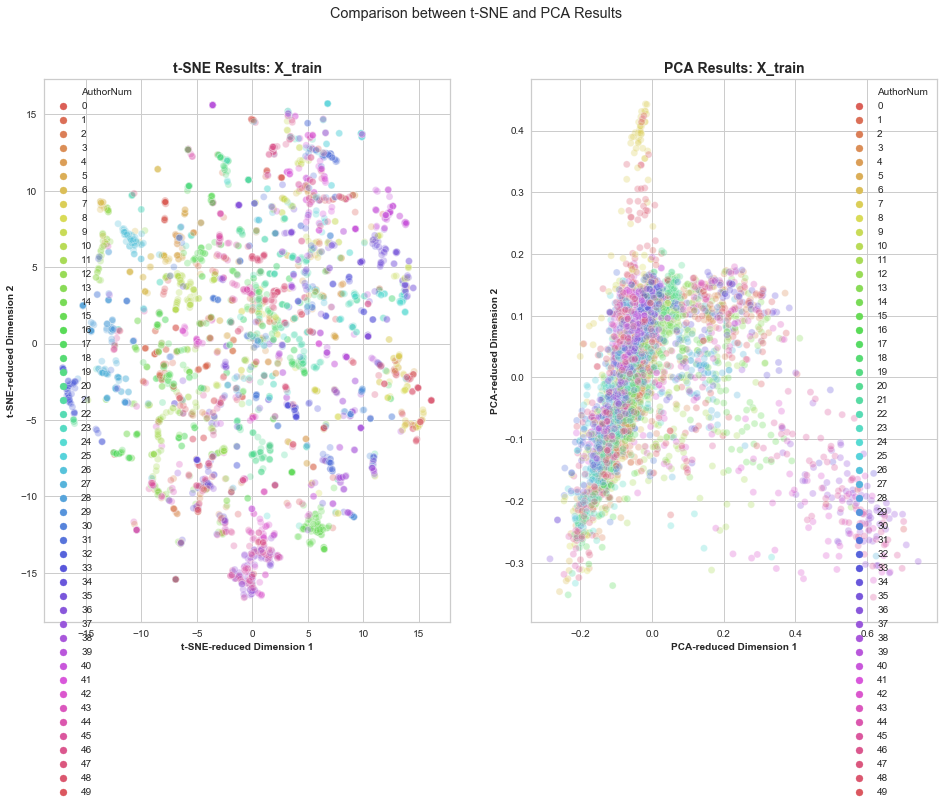

In [434]:
# Plotting PCA vs. t-SNE

# t-SNE plot

dftsne = pd.DataFrame({'Results1':tsne_results[:,0],
                      'Results2':tsne_results[:,1]})

plt.figure(figsize=(16,10))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(
    x="Results1", y="Results2",
    hue=df_train['AuthorNum'],
    palette=sns.color_palette("hls", 50),
    data=dftsne,
    legend="full",
    alpha=0.3,
    ax=ax1
)
plt.title('t-SNE Results: X_train', weight='bold').set_fontsize('14')
plt.xlabel('t-SNE-reduced Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('t-SNE-reduced Dimension 2', weight='bold').set_fontsize('10')

#----------------------------------------
# PCA Plot

ax2 = plt.subplot(1,2,2)
sns.scatterplot(
    x="PCA1", y="PCA2",
    hue=df_train['AuthorNum'],
    palette=sns.color_palette("hls", 50),
    data=dfpca,
    legend="full", # or set to: True
    alpha=0.3,
    ax=ax2
)
plt.title('PCA Results: X_train', weight='bold').set_fontsize('14')
plt.xlabel('PCA-reduced Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('PCA-reduced Dimension 2', weight='bold').set_fontsize('10')

#--------------------------------------
# ready to plot
plt.suptitle('Comparison between t-SNE and PCA Results')
plt.show()

__Analysis:__ There are three problems with the t-SNE results, especially in contrast to the PCA results:

1. If the goal of clustering was to spread the datapoints out as evenly as possible, t-SNE would take the cake. t-SNE avoids curse-of-dimensionality overcrowding via its Gaussian "t-distribution" algorithm. We can safely say it avoided it...pretty well (although notably, there is a small cluster of authors in the middle bottom of the t-SNE graph). 
<br> <br>
2. This kind of distribution does not retain the variance of the original dataset. PCA retains variance.  
<br> <br>
3. Finally, like other stochastic gradient descent models, depending on the hyperparameters, the model can prematurely converge in a local minima. You have to be careful of the results by running the model a couple times.

__In short:__ While there is certainly a time and place for t-SNE, it is not here in this text dataset.

---
### Clustering models not used:
1. __Spectral clustering:__ Clusters pair-wise similarities in the data. This would not be helpful if all features are between -1 and 1 due to tfidf. Also, pair-wise is always slow.

2. __Affinity Propagation:__ Very memory intensive process of finding which datapoints should be cluster centers (and how many cluster centers there should be). Not having the ability to declare n_clusters was something we already did with Mean-Shift, and that played out...not too good.

3. __Hierarchical Dendrogram:__ Tree based model that clusters instead of diverges. Dendrograms look at one feature at a time, making them only suitable for small datasets with small feature spaces - not appropriate here.

---
## Final Section Analysis

When comparing the clusters of the training set and that of the testing set, the clustering appeared to be consistent. This is what we want: our supervised machine learning models would woefully fail if the testing set differed from what it was taught.

Feature analysis was noted through LSA, which identified components that suggested particular groupings of authors. While PCA was used for clustering analyses, LSA vectors will be the input for our supervised models.

---
# 3. Supervised Machine Learning Modeling

Text data is neither continuous nor anywhere close to normal.  Therefore, we will focus only on supervised models that can accommodate non-normal text data. As stated in the very beginning of this project, authors will be the target variable. Of course, because models only handle numerical data, we will be using `df['AuthorNum']` instead of Author as the target variable.

For the models mentioned in the Table of Contents above, we will fit the model with the training data, choose the best one that provides the best R-squared value, then apply predictive modeling to the testing set, obtaining a prediction accuracy score from there.

__Note:__ I hypothesize low accuracy scores. These models will have to be exact to correctly identify the correct author out of 50 possibilities. Moreover, the clustering has showed us that there are a number of components that overlap (after all, our highest Silhouette Score was with _K=2_...). 

With that said, the goal here is to achieve commensurate scores by applying the testing set.

In [453]:
type(y_train)

pandas.core.series.Series

In [436]:
# copied above for reference - setting variables

'''
X_train and X_test are LSA component matricies that have been
reduced down to 580 components via SVD.
'''
X_train = components_train.copy().reset_index()
X_test = components_test.copy().reset_index()

y_train = df_train['AuthorNum']
y_test = df_test['AuthorNum']

# Taking target variable out of feature space
X_train = X_train.drop('Author', axis=1)
X_test = X_test.drop('Author', axis=1)

In [501]:
# creating an ad hoc function to go through model looping
from sklearn import metrics
from sklearn.metrics import accuracy_score

def model_accuracy(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    print('''This model\'s training classification accuracy score is: 
    {}%'''.format(round(model.score(xtrain, ytrain)*100, 2)))
    
    y_pred = model.predict(xtest)
    print('''\nThis model\'s classification accuracy score when 
    \napplying the holdout testing set to the trained model is: 
    {}%'''.format(round(accuracy_score(ytest, y_pred)*100, 2)))

## A. Logistic Regression with LASSO Penalty

Logistic regression determines classifications from sinusoidal probabilities generated from the feature space. While it _is_ used as classification model, the regression characteristic of the model requires it to follow assumptions of accurate regression, including a continuous - and ideally normal - distribution of the data. Therefore, it is doubtful that this model will be one of the most accurate ones applied in this project. Rather, it is used here to _contrast_ the hypothesized success of the non-linear models.

A __LASSO__ (L1 Regularization) penalty will be added to the Logistic Regression. In overly simple terms, the LASSO penalty shrinks the feature space by placing the penalty across the feature space. The larger the feature space - the more effective the penalty. 

The Ridge (L2 Regularization) penalty will __not__ be used. Again, in overly simple terms, this penalty aims to place emphasis on highly correlated features, with the penalty shrinking all other features. Because our feature analysis has not shown one particular component that repeatedly provided explanatory power, this penalty is inapplicable.

In [450]:
ytrainlist = y_train.tolist()
ytestlist = y_test.tolist()

In [466]:
# MODEL 1 - LOGISTIC REGRESSION
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

'''
NOTE:
The only sklearn solver that can handle both
multinomial class and L1 regularization is 'saga'
'''

# experimenting with different penalty severities
# C is the inverse of the strength of the penalty parameter 'lambda' (smaller C --> stronger regularization)

logistregr0 = LogisticRegression(penalty='l1', solver='saga', C=0.05, multi_class='multinomial', max_iter=500)
logistregr1 = LogisticRegression(penalty='l1', solver='saga', C=0.25, multi_class='multinomial', max_iter=500)
logistregr2 = LogisticRegression(penalty='l1', solver='saga', C=0.65, multi_class='multinomial', max_iter=500) 
logistregr3 = LogisticRegression(penalty='l1', solver='saga', C=1, multi_class='multinomial', max_iter=500)
logistregr4 = LogisticRegression(penalty='l1', solver='saga', C=1.5, multi_class='multinomial', max_iter=500)
logistregr5 = LogisticRegression(penalty='l1', solver='saga', C=2, multi_class='multinomial', max_iter=500)
logistregr6 = LogisticRegression(penalty='l1', solver='saga', C=100, multi_class='multinomial', max_iter=500)

logist_list = [logistregr0, logistregr1, logistregr2, logistregr3, 
               logistregr4, logistregr5, logistregr6]

for i in logist_list:
    index_value = logist_list.index(i)
    
    print('\nModel No. ', index_value)
    
    model_accuracy(i, X_train, X_test, y_train, y_test)



Model No.  0
This model's training classification accuracy score is: 
    10.03%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    3.12%

Model No.  1
This model's training classification accuracy score is: 
    50.24%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    2.24%

Model No.  2
This model's training classification accuracy score is: 
    68.08%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    2.32%

Model No.  3
This model's training classification accuracy score is: 
    74.75%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    2.48%

Model No.  4
This model's training classification accuracy score is: 
    80.4%

This model's classification accuracy score when 
    
applying the holdout testing set to the 

C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


This model's training classification accuracy score is: 
    99.97%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    2.08%


__Analysis:__
Surprisingly, the training scores are not too bad. However, it is clear from the testing set that the trained model learned nothing.  In other words, it is having difficulty drawing connections between characteristics tailoring to a specific author. With __a dummy score of 2% (1/50 chance of guessing the right author)__, it is doing slightly better than complete baseline. 

__What does this mean?:__ It is apparent that there is _something_ within the feature space that is creating connections that establish a correlation between X and Y. The feature space may be too broad or too amorphous for the model to find where that correlation is. If I had unlimited time and unlimited processing resources, I would increase iterations to allow the model to figure out that correlation...but I don't.

On that note, running seven logistic regression models took FOREVER (and probably doubled my utility bill). Model No. 6 in particular made me think the kernel died. Moving forward, `n_jobs` or `max_iter` will be tapered to account for the swarth of modeling to be done.

---
## B. K-Nearest Neighbors

Distance analysis from values within the feature space. There is a diminishing return with more neighbors (think of clustering).

In [502]:
# MODEL 2 - KNN
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=3)
knn3 = KNeighborsClassifier(n_neighbors=5)
knn4 = KNeighborsClassifier(n_neighbors=10)
knn5 = KNeighborsClassifier(n_neighbors=20)

knn_list = [knn1, knn2, knn3, knn4, knn5]

knn1.fit(X_train, y_train)

for i in knn_list:
    index_value = knn_list.index(i) + 1
    
    print('\nModel No. ', index_value)
    
    model_accuracy(i, X_train.astype('int64'), X_test, list(y_train.astype('int64')), list(y_test))


TypeError: object of type 'CategoricalDtype' has no len()

In [506]:
import sklearn
sklearn.__version__

'0.20.1'

__Analysis:__

I received a `TypeError: object of type 'CategoricalDtype' has no len()`. This is a series-pandas datatype.  This error is peculiar for two reasons: specifically in the KNN code, I attempt to get around this error by explicitly declaring the input variables to be a different datatype. No matter the datatype, this same error arises. The second peculiarity is that I obviously use the exact same input for all of the classifiers. Why this error is thrown for some models but not others - without any discernable pattern of a specific _kind_ of model throwing this error - is beyond me.

After excessive research, I have found that this error is a known issue with sklearn version 0.20.1. As you can see in the above cell, that is the version I am using. I have since updated sklearn to version 0.21.1; however, when re-running `sklearn.__version__`, I still see a 0.20.1.

Presumably, I would have to restart the kernel to have the update be applied to the project...which means that I would have to run this all over again. I will expressly decline to do that. KNN is similar _enough_ to our clustering methods that its analysis is not vital to the conclusions made within this project.

---
## C. SVM Classifier

Support Vector Machines are good at performing "kernel tricks" to get around the natural linearity of the model. Modifying dimensionality in this way exemplifies how it can work well in higher dimensions, i.e., a large feature space.

In [485]:
# MODEL 3 - SVM CLASSIFIER

from sklearn.svm import SVC

# using default 'rbf' kernel
# using default tolerance for stopping criterion (0.001) 

svm1 = SVC(C=0.01, max_iter=500)
svm2 = SVC(C=0.5, max_iter=500)
svm3 = SVC(C=2, max_iter=500)

svm_list = [svm1, svm2, svm3]

for i in svm_list:
    index_value = svm_list.index(i) + 1
    
    print('\nModel No. ', index_value)
    
    model_accuracy(i, X_train, X_test, y_train, y_test)



Model No.  1


C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


This model's training classification accuracy score is: 
    70.35%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    1.76%

Model No.  2


C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


This model's training classification accuracy score is: 
    70.35%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    1.76%

Model No.  3


C:\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


This model's training classification accuracy score is: 
    70.35%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    1.76%


__Analysis:__
This text data has been extremely finnecky, and when it does work, the kernel hangs like no other. These dismal values likely come from me putting a low number on the max_iter. I just don't want it to crash. In any event, SVC is not the best model.

## D. Random Forest Classifier

While the model may have difficulty in choosing the best feature out of such a large feature space, its non-linear nature is directly suitable for this kind of dataset.

In [500]:
# MODEL 4 - RANDOM FOREST CLASSIFIER
from sklearn import ensemble

rfc1 = ensemble.RandomForestClassifier(n_estimators=175, criterion='gini', max_depth=5)
rfc2 = ensemble.RandomForestClassifier(n_estimators=350, criterion='gini', max_depth=5)

rfc_list = [rfc1, rfc2]

for i in rfc_list:
    index_value = rfc_list.index(i) + 1
    
    print('\nModel No. ', index_value)
    
    model_accuracy(i, X_train, X_test, y_train, y_test)


Model No.  1


TypeError: object of type 'CategoricalDtype' has no len()

__Analysis:__

The same `TypeError` found in KNN arose with the Random Forest model. Again, I will express decline to restart the kernel and re-run _everything_ in the hopes of overcoming this error, which - again - is something I feel comfortable solely blaming sklearn for.

Below is an analysis on AdaBooster ensemble model, which incorporates a Random Forest structure but adds a significant boosting component to it. Because of the similarity, there is no need to separately have the data be analyzed by Random Forest.

---
## E. Adaptive Boosting Classifier

Similar to a random forest but with the added "boosting" ability.

In [488]:
# MODEL 5 - ADABOOSTING MODEL
from sklearn.ensemble import AdaBoostClassifier

# default n_estimators=50, so I'm really going for broke here!

adaboost1 = AdaBoostClassifier(n_estimators=20, learning_rate=1)
adaboost2 = AdaBoostClassifier(n_estimators=50, learning_rate=1)
adaboost3 = AdaBoostClassifier(n_estimators=100, learning_rate=1)

ada_list = [adaboost1, adaboost2, adaboost3]

for i in ada_list:
    index_value = ada_list.index(i) + 1
    
    print('\nModel No. ', index_value)
    
    model_accuracy(i, X_train, X_test, y_train, y_test)



Model No.  1
This model's training classification accuracy score is: 
    13.41%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    4.0%

Model No.  2
This model's training classification accuracy score is: 
    15.17%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    4.32%

Model No.  3
This model's training classification accuracy score is: 
    15.49%

This model's classification accuracy score when 
    
applying the holdout testing set to the trained model is: 
    4.8%


__Analysis:__
Weirdly enough, this has the highest testing set score but the lowest training score. A good bonus is that it is fast!!!! It has been said that [tree boosting models are usually the best at getting a good score fast.](https://brage.bibsys.no/xmlui/handle/11250/2433761)

# 4. Final Analysis

The sparse shape of the text data proves to be the biggest obstacle in terms of proper modeling. This makes unsupervised learning and feature selection all the more important. Obviously, with fewer features, the impact of reducing dimensionality is mitigated. This proved to be a huge bonus when performing unsupervised analysis on the testing set as opposed to the training set...although they both suffered when clustering algorithms were set to K=2. 

Over-reducing the feature space for the sake of efficiency as well as thinking that "simpler is better" resulted in modeling scores to be dismal. Likewise, the initial decision to do `min_df=5` on the tfidf vectorizer may have not paid off. Perhaps there is a word unique to an author, but s/he never uses it more than twice in an article. If that were the case, accuracy could have greatly improved.

As far as supervised modeling goes, it is not surprising that non-linear models such as AdaBooster fared better than linear ones such as LogisticRegression. Because text data does not have a point of central tendency or any sense of continuity in the data, non-linear models are pretty much required for baseline accuracy. Additionally, choosing LSA over PCA is important for this reason; PCA operates on a normal distribution. Why LSA did not cluster well is something beyond my knowledge.

As a final note: classifying 50 text authors is difficult! Perhaps there is a way to subsample it and do it that way?